In [1]:
import numpy as np
import pandas as pd
import io

In [17]:
lang = 'hu'
lowercase = False

In [18]:
# corpus = pd.read_csv(f'XED/AnnotatedData/{lang}-annotated.tsv', sep='\t', header=None)
corpus = pd.read_csv(f'XED/Projections/{lang}-projections.tsv', sep='\t', header=None)

In [19]:
def tobinlabels(labels):
    intlabels = [int(label) for label in labels.split(', ')]
    positive = 0; negative = 0
    if not set(intlabels).isdisjoint([1, 3, 4, 6]):
        negative = 1
    if not set(intlabels).isdisjoint([2, 5, 8]):
        positive = 1
    if positive and not negative:
        return 1
    elif negative and not positive:
        return 0
    else:
        return -1

In [20]:
corpus.head()

,0,1
0,Mi történt veled?,"4, 7"
1,Az üzlet kifújt.,6
2,"Ha nem lenne vérdíj a fejünkön, nem itt lennénk.",4
3,Igyunk a régi időkre.,"2, 5"
4,"Úgyse jó semmire, Kid.",6


In [21]:
for i, sentence in enumerate(corpus[0]):
    try:
        a = (".xml.gz" not in sentence )
    except:
        print(i, sentence)

In [22]:
# Pos/Neg labels
corpus[1] = corpus[1].map(tobinlabels)
corpus = corpus[corpus[1] >= 0]
corpus = corpus.reset_index(drop=True)

In [23]:
# Removing corrupted rows
print(corpus.shape)
not_corrupted = [".xml.gz" not in sentence for sentence in corpus[0]]
corpus = corpus[not_corrupted]
corpus = corpus.reset_index(drop=True)
print(corpus.shape)

(4821, 2)
(4821, 2)


In [24]:
corpus.head()

,0,1
0,Mi történt veled?,0
1,Az üzlet kifújt.,0
2,"Ha nem lenne vérdíj a fejünkön, nem itt lennénk.",0
3,Igyunk a régi időkre.,1
4,"Úgyse jó semmire, Kid.",0


In [25]:
# bert tokenizer
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
models = {
    ('en', False): 'bert-base-cased',
    ###
    ('ar', False): 'asafaya/bert-base-arabic',
    ('bg', False): 'anon-submission-mk/bert-base-macedonian-bulgarian-cased',
    ('br', False): 'neuralmind/bert-base-portuguese-cased',
    ('cn', False): 'bert-base-chinese',
    ('da', True): 'Maltehb/danish-bert-botxo',
    ('de', False): 'bert-base-german-cased',
    ('es', False): 'dccuchile/bert-base-spanish-wwm-cased',
    ('et', False): 'tartuNLP/EstBERT',
    ('eu', False): 'ixa-ehu/berteus-base-cased',
    ('fa', False): 'HooshvareLab/bert-base-parsbert-uncased',
    ('fr', False): 'dbmdz/bert-base-french-europeana-cased',
    ('gl', False): 'dvilares/bertinho-gl-base-cased',
    ('he', False): 'avichr/heBERT',
    ('hu', False): 'SZTAKI-HLT/hubert-base-cc',
}
# models = {
#     "english_base_cased": ('bert-base-cased',False),
#     "english_large_cased": ('bert-large-cased',False),
#     "english_base_uncased": ('bert-base-uncased',True),
#     "english_large_uncased": ('bert-large-uncased',True),
#     "finnish_cased": ('TurkuNLP/bert-base-finnish-cased-v1',False),
#     "finnish_uncased": ('TurkuNLP/bert-base-finnish-uncased-v1',False),
#     "dutch": ('wietsedv/bert-base-dutch-cased',False),
#     "chinese": ('bert-base-chinese',False),
#     "german": ('bert-base-german-cased',False),
#     "arabic": ('asafaya/bert-base-arabic',False),
#     "greek": ('nlpaueb/bert-base-greek-uncased-v1',False),
#     "turkish": ('dbmdz/bert-base-turkish-cased',False)
# }
bert_model_name = models[(lang, lowercase)]
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=lowercase)

In [26]:
# for i in range(10):
#     sentence = corpus[0][i]
#     print(sentence, tokenizer.encode(sentence))
#     print('------')

In [27]:
lens = []
for sentence in corpus[0]:
    lens.append(len(tokenizer.encode(sentence)))
print(max(lens), corpus[0][np.argmax(lens)])

83 Mindennek a titokban tartása a tény, hogy bőven van választási lehetőségünk, hogy elérjük a csillagokat és barátságos szomszédainkat más civilizációkkal az információ, az erőforrások, a tudás, a spirituális betekintés és értékek megosztásában.


In [28]:
bert_model = BertModel.from_pretrained(bert_model_name)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
batch_size = 4
ind = 0
X = np.zeros((corpus.shape[0], 768))
while ind < corpus.shape[0]:
    encoding = tokenizer.batch_encode_plus(
          corpus[0][ind:ind+batch_size],
          add_special_tokens=True,
          truncation=True,
          max_length=100,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
    )
#     print(encoding['input_ids'].shape, encoding['attention_mask'].shape)
    _, pooled_output = bert_model(
      input_ids=encoding['input_ids'],
      attention_mask=encoding['attention_mask'],
      return_dict=False,
    )
    X[ind:ind+batch_size] = pooled_output.detach().cpu().numpy()
    ind += batch_size
    if ind % 100 == 0: 
        print(f"{ind}/{corpus.shape[0]}")

100/4821
200/4821
300/4821
400/4821
500/4821
600/4821
700/4821
800/4821
900/4821
1000/4821
1100/4821
1200/4821
1300/4821
1400/4821
1500/4821
1600/4821
1700/4821
1800/4821
1900/4821
2000/4821
2100/4821
2200/4821
2300/4821
2400/4821
2500/4821
2600/4821
2700/4821
2800/4821
2900/4821
3000/4821
3100/4821
3200/4821
3300/4821
3400/4821
3500/4821
3600/4821
3700/4821
3800/4821
3900/4821
4000/4821
4100/4821
4200/4821
4300/4821
4400/4821
4500/4821
4600/4821
4700/4821
4800/4821


In [15]:
y = corpus[1].to_numpy()
print(X.shape, y.shape, y.mean(), X.min(), X.max(), np.isfinite(X).all())

(3717, 768) (3717,) 0.4457896152811407 -0.9999971389770508 0.999997079372406 True


### --------

### Little test

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4567, 768) (1958, 768) (4567,) (1958,)


In [18]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("f1:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6853932584269663
f1: 0.6230110159118728


/home/ehsan/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### --------

In [113]:
u, s, vt = np.linalg.svd(X)

In [114]:
import matplotlib.pyplot as plt

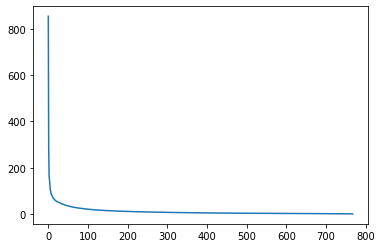

In [115]:
plt.clf()
plt.plot(s)
plt.show()

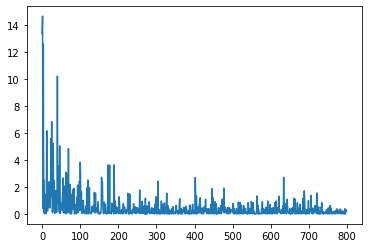

In [118]:
plt.clf()
dot_prods = (u.T @ (y - 0.5))**2
plt.plot(dot_prods[:800])
plt.show()

In [16]:
np.save(f'embeddings/bert_{lang}_X.npy', X)
np.save(f'embeddings/bert_{lang}_y.npy', y)